In [1]:
from collections import defaultdict
from operator import itemgetter

In [2]:
from tqdm import tqdm

In [3]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import softmax
from sklearn.metrics import median_absolute_error

In [4]:
from bgg_client import BggSession
from bgg_client.utils.serialization import dump_struct, load_struct

In [5]:
from collaborative_filtering import utils as cf_utils
from collaborative_filtering.utils import preprocessing as cf_preproc
from collaborative_filtering import LatentFactorModel
from collaborative_filtering.metrics import elementwise_scoring

---

In [6]:
SNAPSHOT_ITER = 100
GAMES_FILENAME = 'games.pkl'
RATINGS_FILENAME = 'users_rating.pkl'


THREAD_FORMAT_LINK = 'https://boardgamegeek.com/thread/{}'

---

In [7]:
bgg_session = BggSession()

---

In [8]:
FIRST_OP, SECOND_OP = itemgetter(0), itemgetter(1)


def print_thread_links(users_threads, user, game_id):
    for forum, threads in users_threads[user][game_id].items():
        print(forum, ':')
        print(*['\t' + THREAD_FORMAT_LINK.format(thread) for thread in threads], sep='\n')

In [9]:
def graph_stat(graph):
    print(f'''
    Number of nodes: {graph.number_of_nodes()}
    Number of Edges: {graph.number_of_edges()}
    Average Degree: {np.mean([degree for _, degree in graph.degree()]):.3f}
    Degree Assortativity Coef: {nx.degree_assortativity_coefficient(graph):.3f}
    ''')


def evaluate_stat(graph, graph_layout, stat, plot_options):
    stat_name, stat_callable = stat
    stat = stat_callable(graph)
    
    figure, axes = plt.subplots(2, 1, figsize=(15, 12 * 2))
    graph_ax, hist_ax = axes.flatten()
    
    nodes = nx.draw_networkx_nodes(
        graph, pos=graph_layout,
        nodelist=list(stat.keys()),
        node_color=list(stat.values()),
        cmap='viridis',
        node_size=plot_options['node_size'],
        ax=graph_ax,
    )
    nx.draw_networkx_edges(graph, pos=graph_layout, ax=graph_ax, width=plot_options['width'])
    
    figure.colorbar(nodes, ax=graph_ax)
    
    
    hist_ax.hist(stat.values(), alpha=.5, bins=30)
    hist_ax.grid()
    hist_ax.set_title(stat_name)
    
    return sorted(stat.items(), key=SECOND_OP, reverse=True)

---

# Data Collecting

### Load Hottest Board Games

In [ ]:
games = bgg_session.get_hotest(BoardGame)


for i, game in enumerate(games):
    try:
        forumlist = bgg_session.get_forumlist(game.id)
        game.load_forumlist(forumlist)
        
        if i % SNAPSHOT_ITER == 0:
            dump_struct(games, GAMES_FILENAME)
        
        print(i, game.id, 'SUCCESS', end='')
    except Exception as exc:
        print(i, game.id, 'FAILED')
        
dump_struct(games, GAMES_FILENAME)

---

### Load Users Rating

In [ ]:
users_rating = dict()
# users_rating = load_struct('_users_rating')
for i, username in enumerate(tqdm(users_threads, desc='User rating collection')):
    if username in users_rating:
        continue
        
    rates = bgg_session.get_user_rating(username, ids)
    users_rating[username] = rates
    
    if i % SNAPSHOT_ITER == 0:
        dump_struct(users_rating, RATINGS_FILENAME)
        
dump_struct(users_rating, RATINGS_FILENAME)

---

### Load Snapshots

In [10]:
games = load_struct(GAMES_FILENAME)
users_rating = load_struct(RATINGS_FILENAME)

---

### Auxiliary

In [11]:
bg_id2name = {game.id: game.name for game in games}
bg_name2id = {game.name: game.id for game in games}

---

---

# Data processing

### Collect Users Threads

In [12]:
users_threads = defaultdict( # User
    lambda: defaultdict( # Game
        lambda: defaultdict( # Forum
            list # Threads
        )
    )
)

for game in games:
    for title, forum in game.items():
        for thread in forum.threads:
            users_threads[thread.author][game.id][title] += [thread.id]

---

# Edges Construction

### Reply Edges

In [13]:
reply_edges = defaultdict(lambda: defaultdict(float))

for game in games:
    for _, forum in game.items():
        for thread in forum.threads:
            author = thread.author
            users = set(FIRST_OP(post) for post in thread.posts if FIRST_OP(post))
            
            if author not in users_rating:
                continue
            
            for user in users:
                if user not in users_rating:
                    continue
                if user == author:
                    continue
                reply_edges[game.id][(user, author)] += 1

### Reply Edges w. rating

In [14]:
known_reply_edges = defaultdict(lambda: defaultdict(float))

for game in games:
    for _, forum in game.items():
        for thread in forum.threads:
            author = thread.author
            users = set(FIRST_OP(post) for post in thread.posts if FIRST_OP(post))
            
            if author not in users_rating:
                continue
            if game.id not in users_rating[author]:
                continue
            
            for user in users:
                if user not in users_rating:
                    continue
                if user == author:
                    continue
                if game.id not in users_rating[user]:
                    continue
                known_reply_edges[game.id][(user, author)] += 1

### Reply Edges w. rating weighted by forum

In [15]:
uniq_forums = set()
for game in games:
    for title in game:
        uniq_forums.add(title)

In [16]:
uniq_forums

{'Crowdfunding',
 'General',
 'News',
 'Organized Play',
 'Play By Forum',
 'Reviews',
 'Rules',
 'Sessions',
 'Strategy',
 'Variants'}

In [17]:
forum_weight = {
    'Crowdfunding': 2.0,
    'General': 2.0,
    'News': 2.0,
    'Organized Play': 4.0,
    'Play By Forum': 1.0,
    'Reviews': 10.0,
    'Rules': 1.0,
    'Sessions': 4.0,
    'Strategy': 6.0,
    'Variants': 8.0,
}


forum_weight = dict(zip(
    forum_weight.keys(),
    softmax(list(forum_weight.values()))
))

In [18]:
sorted(forum_weight.items(), key=SECOND_OP, reverse=True)

[('Reviews', 0.8621718062840782),
 ('Variants', 0.1166822656020777),
 ('Strategy', 0.015791227463946855),
 ('Organized Play', 0.002137110241487025),
 ('Sessions', 0.002137110241487025),
 ('Crowdfunding', 0.00028922641983951223),
 ('General', 0.00028922641983951223),
 ('News', 0.00028922641983951223),
 ('Play By Forum', 0.00010640045370257673),
 ('Rules', 0.00010640045370257673)]

In [19]:
weighted_known_reply_edges = defaultdict(lambda: defaultdict(float))

for game in games:
    for title, forum in game.items():
        for thread in forum.threads:
            author = thread.author
            users = set(FIRST_OP(post) for post in thread.posts if FIRST_OP(post))
            
            if author not in users_rating:
                continue
            if game.id not in users_rating[author]:
                continue
            
            for user in users:
                if user not in users_rating:
                    continue
                if user == author:
                    continue
                if game.id not in users_rating[user]:
                    continue
                weighted_known_reply_edges[game.id][(user, author)] += forum_weight[title]

---

# Experiments workaround

In [139]:
SEED = 443

In [140]:
DEFAULT_FIGSIZE = (15, 12)
PLOT_OPTIONS = {"node_size": 40, "with_labels": False, "width": 0.15}

# Experiments

### Reply experiment

In [26]:
GAME_ID = '246900' # Eclipse

In [142]:
G = nx.DiGraph()
G.add_edges_from(reply_edges[GAME_ID].keys())
G_layout = nx.spring_layout(G, iterations=20, seed=SEED)


graph_stat(G)


    Number of nodes: 864
    Number of Edges: 1872
    Average Degree: 4.333333333333333
    


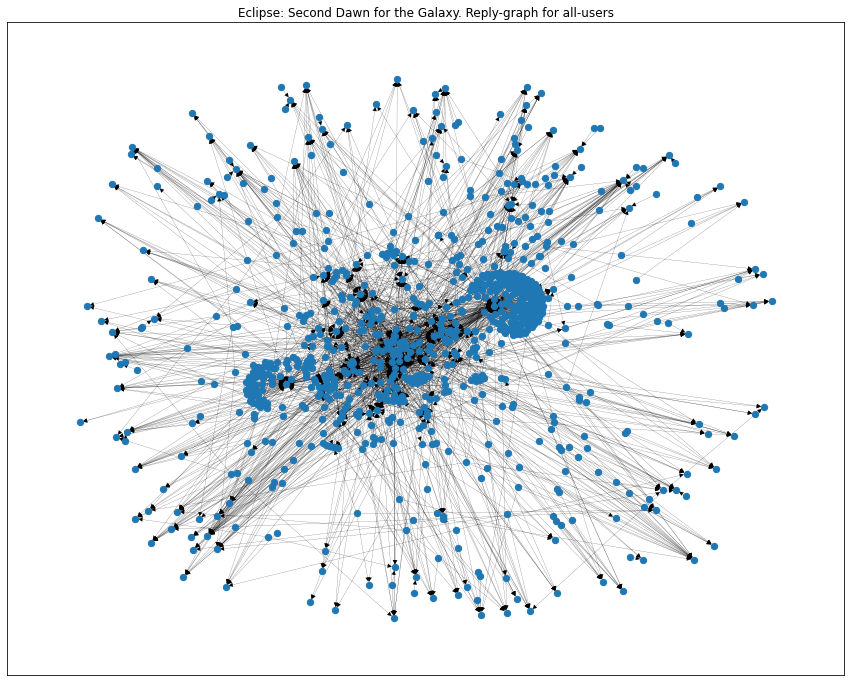

In [143]:
plt.figure(figsize=DEFAULT_FIGSIZE)
nx.draw_networkx(G, pos=G_layout, **PLOT_OPTIONS)

plt.title(f'{bg_id2name[GAME_ID]}. Reply-graph for all-users')
plt.show()

### Reply w. rating

In [144]:
G = nx.DiGraph()
G.add_edges_from(known_reply_edges[GAME_ID].keys())
G_layout = nx.spring_layout(G, iterations=20, seed=SEED)


graph_stat(G)


    Number of nodes: 285
    Number of Edges: 659
    Average Degree: 4.624561403508772
    


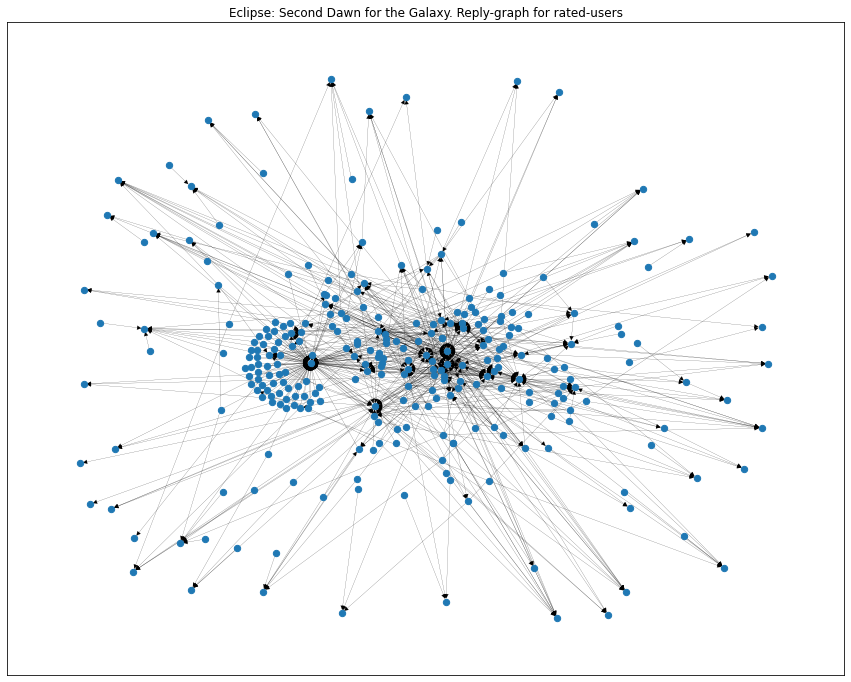

In [145]:
plt.figure(figsize=DEFAULT_FIGSIZE)
nx.draw_networkx(G, pos=G_layout, **PLOT_OPTIONS)

plt.title(f'{bg_id2name[GAME_ID]}. Reply-graph for rated-users')
plt.show()

### Reply exp w. rating and forum-weighting

In [215]:
G = nx.DiGraph()
for edge, weight in weighted_known_reply_edges[GAME_ID].items():
    G.add_edge(FIRST_OP(edge), SECOND_OP(edge), weight=weight)
G_layout = nx.spring_layout(G, iterations=20, seed=SEED)


graph_stat(G)


    Number of nodes: 285
    Number of Edges: 659
    Average Degree: 4.625
    Degree Assortativity Coef: -0.053
    


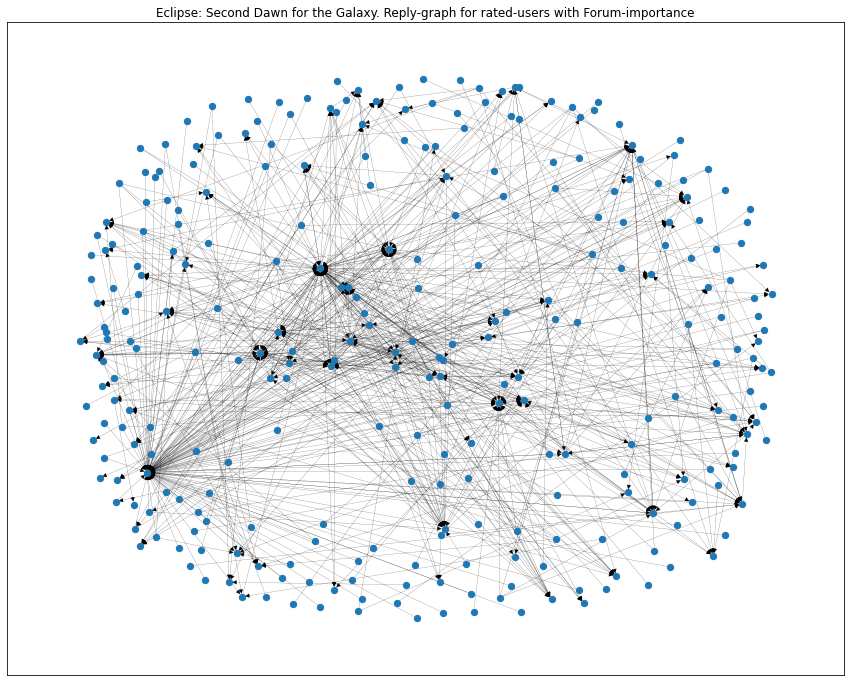

In [216]:
plt.figure(figsize=DEFAULT_FIGSIZE)
nx.draw_networkx(G, pos=G_layout, **PLOT_OPTIONS)

plt.title(f'{bg_id2name[GAME_ID]}. Reply-graph for rated-users with Forum-importance')
plt.show()

##### Centralities

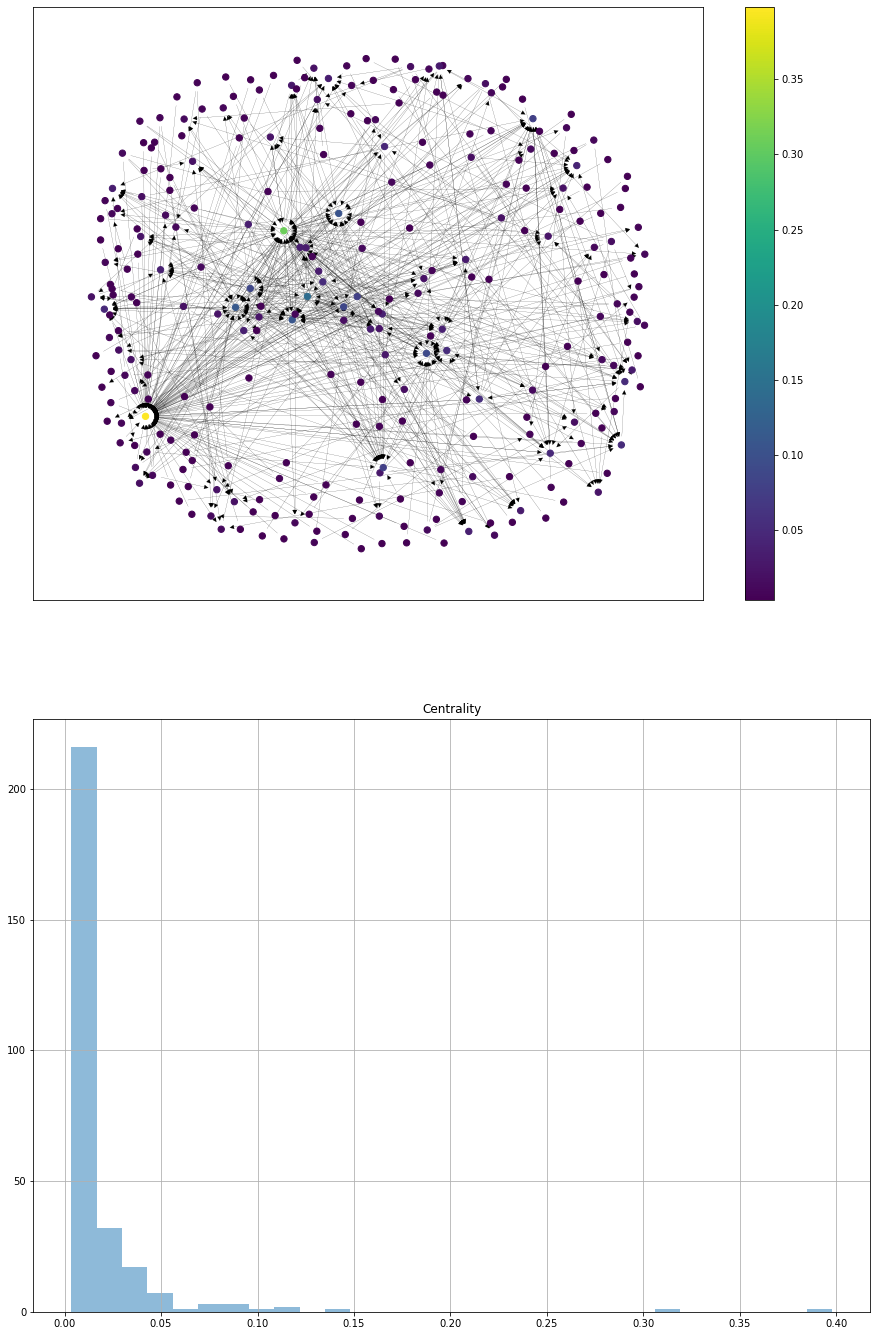

In [231]:
centralities = evaluate_stat(G, G_layout, ('Degree Centrality', nx.centrality.degree_centrality), PLOT_OPTIONS)

In [232]:
for user, centrality in centralities[:10]:
    print('###', user, 'C:', centrality)
    print_thread_links(users_threads, user, GAME_ID)
    print('-' * 50, '\n')

### toniemn C: 0.397887323943662
News :
	https://boardgamegeek.com/thread/2762081
	https://boardgamegeek.com/thread/2686571
	https://boardgamegeek.com/thread/2644433
	https://boardgamegeek.com/thread/2769191
	https://boardgamegeek.com/thread/2737384
	https://boardgamegeek.com/thread/2699767
	https://boardgamegeek.com/thread/2544860
	https://boardgamegeek.com/thread/2387314
	https://boardgamegeek.com/thread/2507321
	https://boardgamegeek.com/thread/2487414
	https://boardgamegeek.com/thread/2457494
Crowdfunding :
	https://boardgamegeek.com/thread/2028697
	https://boardgamegeek.com/thread/2026424
-------------------------------------------------- 

### chrisdk C: 0.3098591549295775
Reviews :
	https://boardgamegeek.com/thread/2460000
General :
	https://boardgamegeek.com/thread/2816590
Strategy :
	https://boardgamegeek.com/thread/2629829
	https://boardgamegeek.com/thread/2805240
	https://boardgamegeek.com/thread/2594318
	https://boardgamegeek.com/thread/2593626
	https://boardgamegeek.com/th

---

##### Page Rank

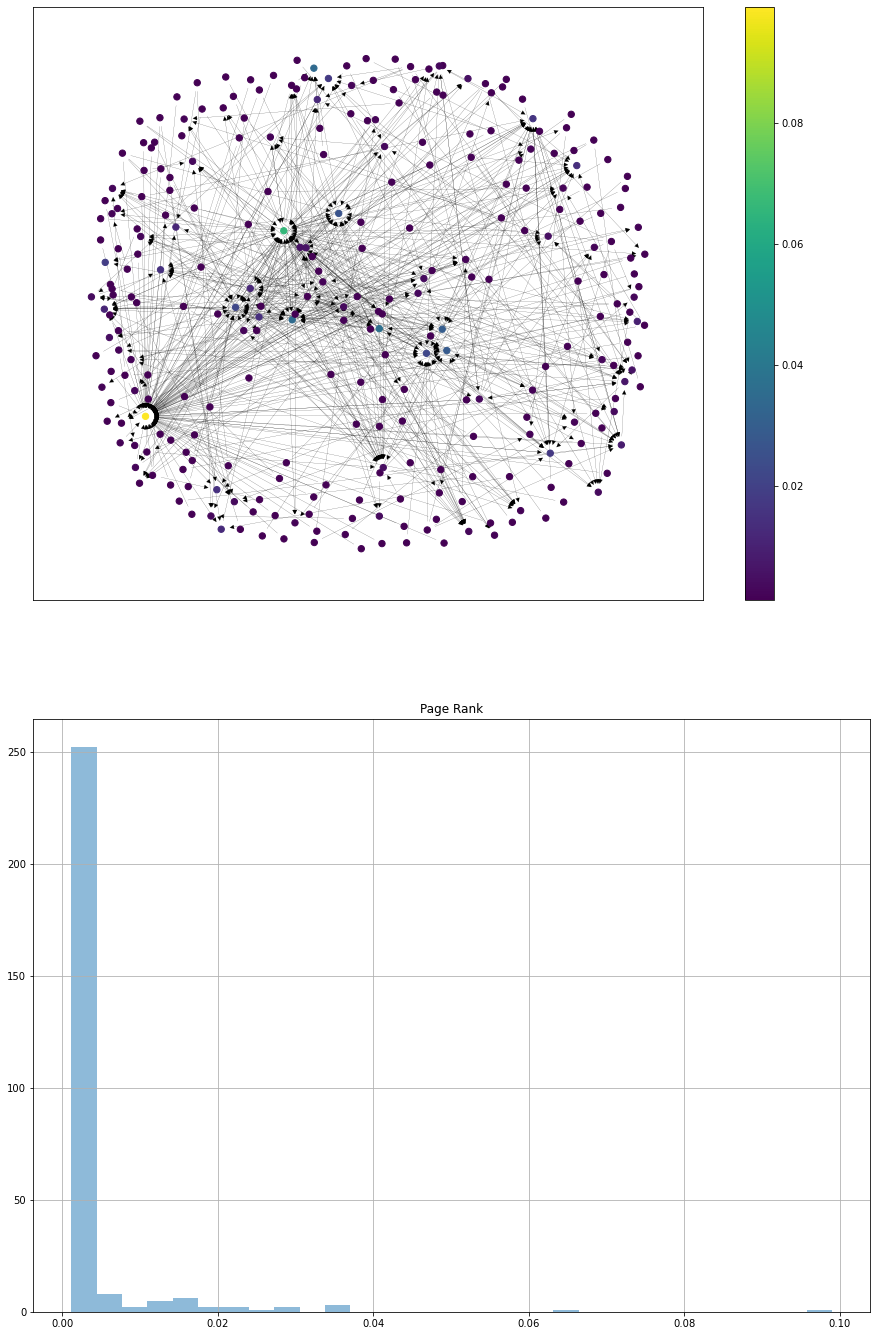

In [233]:
pagerank = evaluate_stat(G, G_layout, ('Page Rank', nx.pagerank), PLOT_OPTIONS)

In [234]:
for user, prank in pagerank[:10]:
    print('###', user, f'Page Rank: {prank:.3f}')
    print_thread_links(users_threads, user, GAME_ID)
    print('-' * 50, '\n')

### toniemn Page Rank: 0.099
News :
	https://boardgamegeek.com/thread/2762081
	https://boardgamegeek.com/thread/2686571
	https://boardgamegeek.com/thread/2644433
	https://boardgamegeek.com/thread/2769191
	https://boardgamegeek.com/thread/2737384
	https://boardgamegeek.com/thread/2699767
	https://boardgamegeek.com/thread/2544860
	https://boardgamegeek.com/thread/2387314
	https://boardgamegeek.com/thread/2507321
	https://boardgamegeek.com/thread/2487414
	https://boardgamegeek.com/thread/2457494
Crowdfunding :
	https://boardgamegeek.com/thread/2028697
	https://boardgamegeek.com/thread/2026424
-------------------------------------------------- 

### chrisdk Page Rank: 0.066
Reviews :
	https://boardgamegeek.com/thread/2460000
General :
	https://boardgamegeek.com/thread/2816590
Strategy :
	https://boardgamegeek.com/thread/2629829
	https://boardgamegeek.com/thread/2805240
	https://boardgamegeek.com/thread/2594318
	https://boardgamegeek.com/thread/2593626
	https://boardgamegeek.com/thread/2585

---

##### Eigenvector Centrality

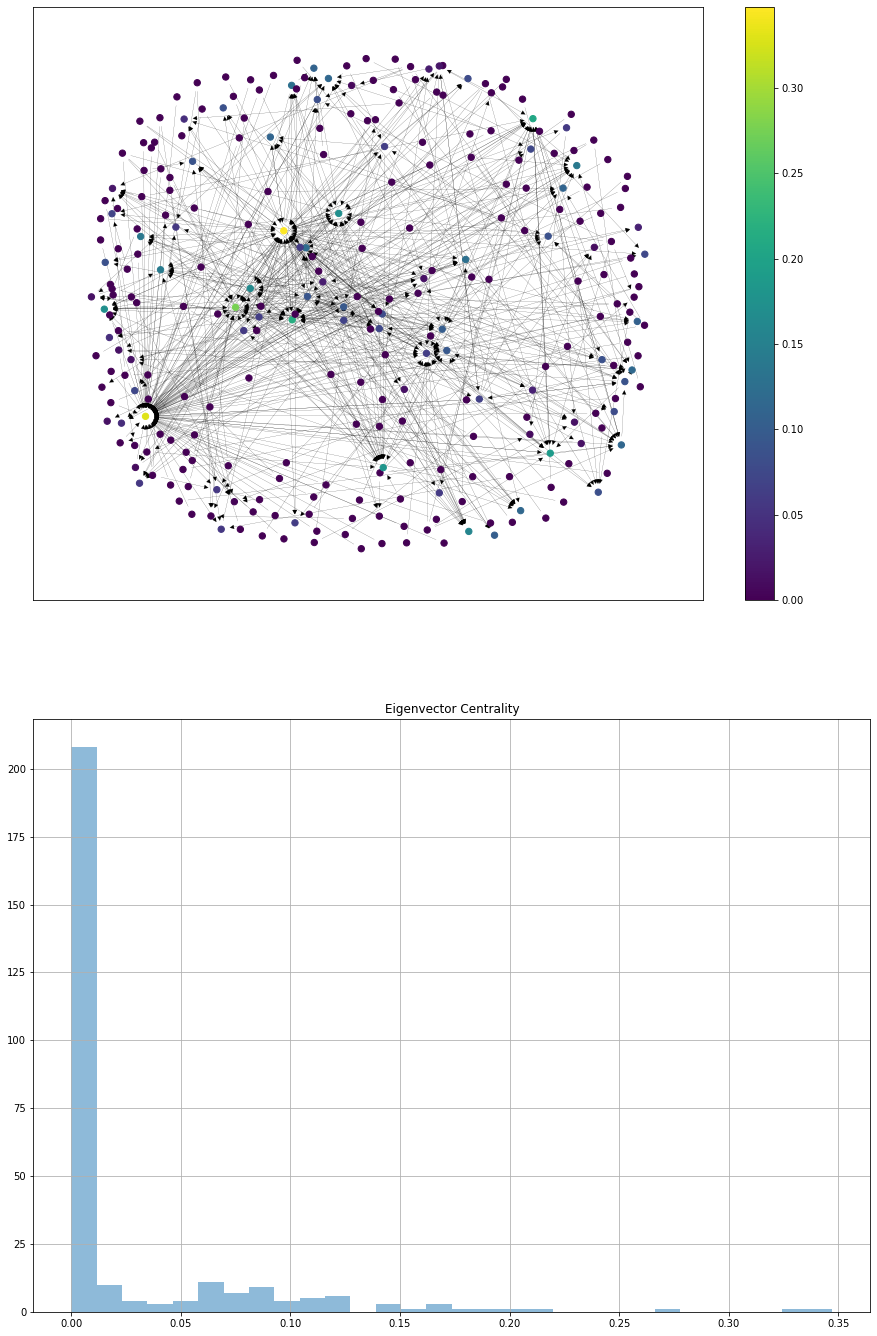

In [235]:
centralities = evaluate_stat(G, G_layout, ('Eigenvector Centrality', nx.centrality.eigenvector_centrality), PLOT_OPTIONS)

In [237]:
for user, centrality in centralities[:10]:
    print('###', user, f'Eigenvector Centralities: {centrality:.3f}')
    print_thread_links(users_threads, user, GAME_ID)
    print('-' * 50, '\n')

### chrisdk Eigenvector Centralities: 0.347
Reviews :
	https://boardgamegeek.com/thread/2460000
General :
	https://boardgamegeek.com/thread/2816590
Strategy :
	https://boardgamegeek.com/thread/2629829
	https://boardgamegeek.com/thread/2805240
	https://boardgamegeek.com/thread/2594318
	https://boardgamegeek.com/thread/2593626
	https://boardgamegeek.com/thread/2585411
	https://boardgamegeek.com/thread/2657527
	https://boardgamegeek.com/thread/2656514
	https://boardgamegeek.com/thread/2669766
-------------------------------------------------- 

### toniemn Eigenvector Centralities: 0.330
News :
	https://boardgamegeek.com/thread/2762081
	https://boardgamegeek.com/thread/2686571
	https://boardgamegeek.com/thread/2644433
	https://boardgamegeek.com/thread/2769191
	https://boardgamegeek.com/thread/2737384
	https://boardgamegeek.com/thread/2699767
	https://boardgamegeek.com/thread/2544860
	https://boardgamegeek.com/thread/2387314
	https://boardgamegeek.com/thread/2507321
	https://boardgamegeek.

---

# Collaborative Filtering

In [20]:
rate_frame = cf_preproc.rate_frame_from_ratemap(users_rating)
users_map, bg_map = cf_preproc.get_idx_mapping(rate_frame)

In [28]:
dump_struct(users_map, 'cf__user_mapping')
dump_struct(bg_map, 'cf__item_mapping')

In [21]:
X_train, X_test = cf_preproc.train_test_split(rate_frame.values, 0.2)

---

In [22]:
lfm = LatentFactorModel(64, 0.5, 0.5, 1)
lfm.fit(X_train)

LFM ALS loop: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


In [23]:
R_test_hat = lfm.P @ lfm.Q.T

print(f'Test MAE: {elementwise_scoring(R_test_hat, X_test, median_absolute_error):.3f}')

Test MAE: 0.989


In [24]:
lfm.dump_hidden_stat('./snapshot/cf')

In [29]:
games

[BoardGame(id='12', name='Ra', yearpublished=1999, minplaytime=45, maxplaytime=60, minplayers=2, maxplayers=5, nplayers_best='4'),
 BoardGame(id='363204', name='FLOE', yearpublished=2023, minplaytime=45, maxplaytime=90, minplayers=1, maxplayers=4, nplayers_best='4+'),
 BoardGame(id='303669', name='Magic Rabbit', yearpublished=2020, minplaytime=3, maxplaytime=3, minplayers=1, maxplayers=4, nplayers_best='2'),
 BoardGame(id='255984', name='Sleeping Gods', yearpublished=2021, minplaytime=60, maxplaytime=1200, minplayers=1, maxplayers=4, nplayers_best='2'),
 BoardGame(id='352697', name='Resist!', yearpublished=2022, minplaytime=20, maxplaytime=40, minplayers=1, maxplayers=1, nplayers_best='1'),
 BoardGame(id='227935', name="Wonderland's War", yearpublished=2022, minplaytime=45, maxplaytime=125, minplayers=2, maxplayers=5, nplayers_best='4'),
 BoardGame(id='311193', name='Anno 1800', yearpublished=2020, minplaytime=120, maxplaytime=120, minplayers=2, maxplayers=4, nplayers_best='3'),
 Board